# HW5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from libsvm.svmutil import *
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

## 1. Gaussian Process

#### Load Data

In [2]:
def load_data(file_path):
    f = open(file_path, 'r')
    line = f.readline()
    
    data = []
    while line:
        nums = line.split(' ')
        data.append([float(n) for n in nums])
        line = f.readline().replace('\n','')
    f.close()        
    
    return np.array(data)

In [3]:
data = load_data('/home/s312657018/TBrain/HW5/data/input.data')
data[:5]

array([[-50.18038796,   1.77474681],
       [-48.33784599,   1.13053693],
       [-43.0202886 ,  -2.47591107],
       [-41.29017074,  -0.66589532],
       [-38.06586017,  -0.47291983]])

### Task 1

Apply Gaussian Process Regression to predict the distribution of f and visualize the result. \
Please use rational quadratic kernel to compute similarities between different points. 

$$ k(x,x')=  \sigma ^2 \left 
 ( 1+ \frac{(x-x')^2}{2\alpha ℓ^2} ​
\right )
^{−\alpha}
 $$

$$K_{train, train} =K_{train, train} + \beta^{-1} I$$

Details of the visualization:
- Show all training data points.
- Draw a line to represent mean of $f$ in range[-60,60]. 
- Mark the 95% confidence interval of $f$.


### Task 2:
Optimize the kernel parameters by minimizing negative marginal log-likelihood, and visualize the result again.

In [4]:
class GaussianProcess:
    def __init__(self, data, beta=5):
        self.X = data.T[0]
        self.Y = data.T[1]
        self.beta = beta
        
    def kernel(self, x1, x2, sigma, alpha, l):
        return sigma * (1 + ((x1 - x2)**2) / (2 * alpha * l**2)) ** (-alpha)

    def gaussian(self, sigma, alpha, l):
        X = self.X.reshape(-1, 1)
        C = self.kernel(X, X.T, sigma, alpha, l)
        C += np.eye(len(X)) / self.beta
        return C
    
    def MLL(self, theta):
        sigma, alpha, l = theta
        
        C = self.gaussian(sigma, alpha, l)
        Y = self.Y.reshape(-1, 1)

        optim = 1/2 * len(self.X) * np.log(2*np.pi) + \
                1/2 * Y.T @ np.linalg.inv(C) @ Y + \
                1/2 * np.log(np.linalg.det(C))            
        return optim.ravel()  
        
    def plotPredict(self, sigma, alpha, l, pred_mu, pred_var, X_test, phase='task1'):
        C_inv = np.linalg.inv(self.gaussian(sigma, alpha, l))
        for i in range(len(pred_mu)):
            k_test = self.kernel(X_test[i], X_test[i], sigma, alpha, l) + 1/self.beta
            k_train_test = self.kernel(self.X, X_test[i], sigma, alpha, l)
            pred_mu[i] =  k_train_test @ C_inv @ self.Y
            pred_var[i] = k_test - k_train_test.T @ C_inv @ k_train_test
  
        plt.plot(self.X, self.Y, 'bo', markersize=5)
        plt.plot(X_test, pred_mu, color='black')
        plt.fill_between(X_test.flatten(), 
                        pred_mu + 1.96 * np.sqrt(pred_var), 
                        pred_mu - 1.96 * np.sqrt(pred_var), 
                        color='purple', alpha=0.2, label='95% Confidence Interval')
        plt.title(f'{phase} data point with sigma={sigma:.2f}, alpha={alpha:.2f}, l={l:.2f}')
        plt.xlim(-60, 60)
        plt.show()
    
    def Result(self, sigma, alpha, l, phase = 'task1'):
        X_test = np.linspace(-60, 60, 500).reshape(-1, 1)
        pred_mu = np.zeros(500)
        pred_var = np.zeros(500)            
        if phase == 'task1':
            self.plotPredict(sigma, alpha, l, pred_mu, pred_var, X_test, phase)
            
        elif phase == 'task2':
            theta = minimize(self.MLL, [sigma, alpha, l],
                             bounds = ((1e-8, 1e6), (1e-8, 1e6), (1e-8, 1e6)))
            
            sigma, alpha, l = theta.x
            self.plotPredict(sigma, alpha, l, pred_mu, pred_var, X_test, phase)
    

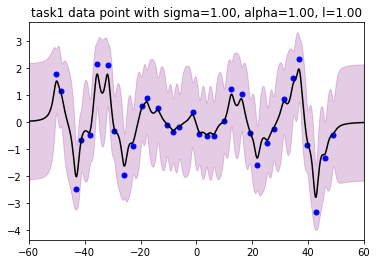

In [5]:
Gaussian = GaussianProcess(data)
Gaussian.Result(1, 1, 1, phase='task1')

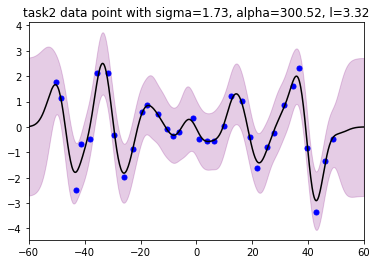

In [6]:
Gaussian.Result(1, 1, 1, phase='task2')

----

## 2. SVM on MNIST dataset

### Use SVM models to tackle classification on images of hand-written digits
#### Load Data

#### Training data
- X_train.csv is a 5000x784 matrix. Every row corresponds to a 28x28 gray-scale image. 
- Y_train.csv is a 5000x1 matrix, which records the class of the training samples.

#### Testing data
- X_test.csv is a 2500x784 matrix. Every row corresponds to a 28x28 gray-scale image. 
- Y_test.csv is a 2500x1 matrix, which records the class of the test samples.


In [4]:
def load_data(file_path):
    f = open(file_path, 'r')
    line = f.readline()
    
    data = []
    while line:
        nums = line.split(',')
        data.append([float(n) for n in nums])
        line = f.readline().replace('\n','')
    f.close()        
    
    return np.array(data)

In [5]:
X_train = load_data('/home/s312657018/TBrain/HW5/data/X_train.csv')
X_test = load_data('/home/s312657018/TBrain/HW5/data/X_test.csv')
Y_train = load_data('/home/s312657018/TBrain/HW5/data/Y_train.csv').ravel()
Y_test = load_data('/home/s312657018/TBrain/HW5/data/Y_test.csv').ravel()

#### Task 1:
Use different kernel functions (linear, polynomial, and RBF kernels) and have comparisons between their performance.


In [ ]:
def SVM_kernel(idx=0, phase='linear'):
    '''
    Parameters:
    - idx: Index representing the type of kernel (0: linear, 1: polynomial, 2: RBF).
    - phase: String representing the kernel type (e.g., 'linear', 'polynomial', 'RBF').
    '''
    train_prob = svm_problem(Y_train, X_train)

    print(f"{phase} kernel:")
    kernel = svm_train(train_prob, f'-t {idx}')
    svm_predict(Y_test, X_test, kernel)
    

In [ ]:
SVM_kernel(idx=0, phase='linear')
SVM_kernel(idx=1, phase='polynomial')
SVM_kernel(idx=2, phase='RBF')

linear kernel:
Accuracy = 95.08% (2377/2500) (classification)

polynomial kernel:
Accuracy = 34.68% (867/2500) (classification)

RBF kernel:
Accuracy = 95.32% (2383/2500) (classification)



#### Task 2:
Please use C-SVC (you can choose by setting parameters in the function input, C-SVC is soft-margin SVM). Since there are some parameters you need to tune for, please do the grid search for finding parameters of best performing model. For instance, in C-SVC you have a parameter C, and if you use RBF kernel you have another parameter γ, you can search for a set of (C, γ) which gives you best performance in cross-validation. (There are lots of sources on the internet, just google for it.)

In [6]:
def combine_linear_rbf(x, y, gamma):
    """
    Combine Linear and RBF kernels to create a custom kernel matrix.
    
    Parameters:
    - x: Feature matrix 
    - y: Feature matrix (same or different set as x).
    - gamma: Parameter for the RBF kernel.

    Returns:
    - new_k: Combined kernel matrix (Linear + RBF), formatted for LibSVM.
    """
    linear = x @ y.T
    rbf = np.exp(-gamma * cdist(x, y, 'sqeuclidean'))
    new_k = linear + rbf
    new_k = np.hstack((np.arange(1, len(x)+1).reshape(-1, 1), new_k))
    return new_k

In [48]:
def grid_search_cv(param_c, param_g=None, param_d=None, param_r=None, kernel='linear'):
    results = []
    best_c, best_g, best_d, best_r, best_acc = None, None, None, None, 0
    
    print('*'*25, f'{kernel} kernel', '*'*25)
    records = f'{kernel} kernel with best parameter '
    if kernel == 'linear':
        for c in param_c:
            acc = svm_train(Y_train, X_train, f'-t 0 -v 4 -c {c}') 
            results.append((c, acc))
            if acc > best_acc:
                best_c, best_acc = c, acc
        records += f'c={best_c}, best accuarcy={best_acc}'
        
    elif kernel == 'polynomial':
        for c in param_c:
            for g in param_g:
                for d in param_d:
                    for r in param_r:
                        acc = svm_train(Y_train, X_train, f'-t 1 -v 4 -c {c} -g {g} -d {d} -r {r}')
                        results.append((c, g, acc, d, r))
                        if acc > best_acc:
                            best_c, best_g, best_d, best_r, best_acc = c, g, d, r, acc
        records += f'c={best_c}, gamma={best_g}, degree={best_d}, r={best_r}, best accuarcy={best_acc}' 
            
    else:
        for c in param_c:
            for  g in param_g:
                if kernel == 'rbf':
                    acc = svm_train(Y_train, X_train, f'-t 2 -v 4 -c {c} -g {g}')  

                elif kernel == 'combine':
                    new_k = combine_linear_rbf(X_train, X_train, g)
                    train_prob = svm_problem(Y_train, new_k, isKernel=True)
                    acc = svm_train(train_prob, f'-t 4 -v 4 -c {c} -g {g}')
                
                results.append((c, g, acc))
                if acc > best_acc:
                    best_c, best_g, best_acc = c, g, acc
        records += f'c={best_c}, gamma={best_g}, best accuarcy={best_acc}'
    
    print(records)
    return results


In [19]:
def plot_gsResult(param_c, param_g, gs_results):
    heatmap_data = np.zeros((len(param_c), len(param_g)))

    for c_idx, c in enumerate(param_c):
        for g_idx, g in enumerate(param_g):
            for result in gs_results:
                if result[0] == c and result[1] == g:
                    heatmap_data[c_idx, g_idx] = result[2]
    
    max_idx = np.unravel_index(np.argmax(heatmap_data, axis=None), heatmap_data.shape)
    best_c = param_c[max_idx[0]]
    best_g = param_g[max_idx[1]]

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(heatmap_data, annot=True, fmt=".1f", xticklabels=param_g, yticklabels=param_c, cmap="YlGnBu")
    rect = Rectangle((max_idx[1], max_idx[0]), 1, 1, fill=False, color='red', linewidth=2, label=f'Best (C={best_c}, Gamma={best_g}')
    ax.add_patch(rect)
    plt.legend(loc='upper left')
    plt.xlabel('log Gamma')
    plt.ylabel('log C')
    plt.title('Grid Search Accuracy Heatmap')
    plt.show()


In [ ]:
param_c = [0.001, 0.01, 0.1, 1, 10, 100] 

results = grid_search_cv(param_c, kernel='linear')
acc = [result[-1] for result in results]
print('acc:', np.round(acc, 2))

************************* linear kernel *************************
Cross Validation Accuracy = 95.32%
Cross Validation Accuracy = 96.96%
Cross Validation Accuracy = 96.94%
Cross Validation Accuracy = 96.36%
Cross Validation Accuracy = 96.36%
Cross Validation Accuracy = 96.22%
linear kernel with best parameter c=0.01, best accuarcy=96.96000000000001
[95.32 96.96 96.94 96.36 96.36 96.22]


************************* polynomial kernel *************************
Cross Validation Accuracy = 45.88%
Cross Validation Accuracy = 79.36%
Cross Validation Accuracy = 79.28%
Cross Validation Accuracy = 28.3%
Cross Validation Accuracy = 79.3%
Cross Validation Accuracy = 79.3%
Cross Validation Accuracy = 23.98%
Cross Validation Accuracy = 79.24%
Cross Validation Accuracy = 79.18%
Cross Validation Accuracy = 45.56%
Cross Validation Accuracy = 78.14%
Cross Validation Accuracy = 78.78%
Cross Validation Accuracy = 28.32%
Cross Validation Accuracy = 76.78%
Cross Validation Accuracy = 78.14%
Cross Validation Accuracy = 23.7%
Cross Validation Accuracy = 75.26%
Cross Validation Accuracy = 77.34%
Cross Validation Accuracy = 45.52%
Cross Validation Accuracy = 68.74%
Cross Validation Accuracy = 73.28%
Cross Validation Accuracy = 28.26%
Cross Validation Accuracy = 54.48%
Cross Validation Accuracy = 64.72%
Cross Validation Accuracy = 23.78%
Cross Validation Accuracy = 42.7%
Cross Validation Accuracy

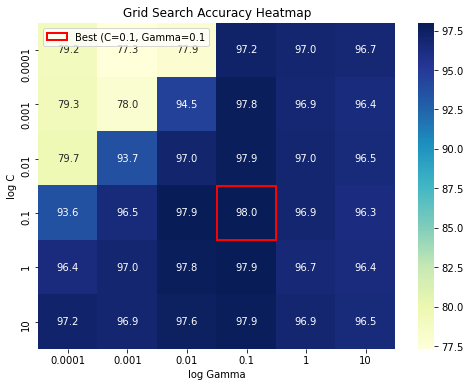

In [49]:
param_c = [0.0001, 0.001, 0.01, 0.1, 1, 10]  
param_g = [0.0001, 0.001, 0.01, 0.1, 1, 10]  

results = grid_search_cv(param_c, param_g, [2, 3, 4], [0, 1, 2], kernel='polynomial')
acc = [result[2] for result in results]
print('acc:', np.round(acc, 2))

plot_gsResult(param_c, param_g, results)

************************* rbf kernel *************************
Cross Validation Accuracy = 80.82%
Cross Validation Accuracy = 89.92%
Cross Validation Accuracy = 48.78%
Cross Validation Accuracy = 20.86%
Cross Validation Accuracy = 78.94%
Cross Validation Accuracy = 36.12%
Cross Validation Accuracy = 80.96%
Cross Validation Accuracy = 92.24%
Cross Validation Accuracy = 48.96%
Cross Validation Accuracy = 20.48%
Cross Validation Accuracy = 78.94%
Cross Validation Accuracy = 36.08%
Cross Validation Accuracy = 92.32%
Cross Validation Accuracy = 96.38%
Cross Validation Accuracy = 54.06%
Cross Validation Accuracy = 20.4%
Cross Validation Accuracy = 79.06%
Cross Validation Accuracy = 36.06%
Cross Validation Accuracy = 96.06%
Cross Validation Accuracy = 97.78%
Cross Validation Accuracy = 91.64%
Cross Validation Accuracy = 29.34%
Cross Validation Accuracy = 30.12%
Cross Validation Accuracy = 36.28%
Cross Validation Accuracy = 97.08%
Cross Validation Accuracy = 98.26%
Cross Validation Accuracy = 

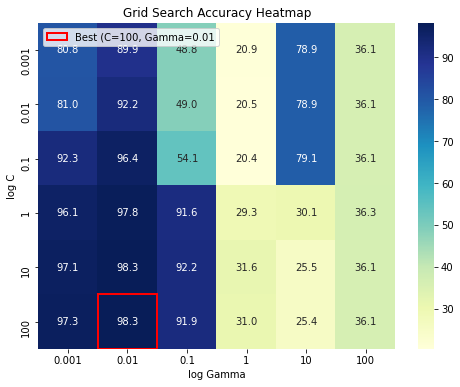

In [44]:
param_c = [0.001, 0.01, 0.1, 1, 10, 100]  
param_g = [0.001, 0.01, 0.1, 1, 10, 100]  

results = grid_search_cv(param_c, param_g, kernel='rbf')
acc = [result[-1] for result in results]
print(np.round(acc, 2))

plot_gsResult(param_c, param_g, results)

In [51]:
train_prob = svm_problem(Y_train, X_train)

# linear
print("linear kernel:")
linear_kernel = svm_train(train_prob, '-t 0 -c 0.01')
linear_pred = svm_predict(Y_test, X_test, linear_kernel)

# polynomial
print("\npolynomial kernel:")
poly_kernel = svm_train(train_prob, '-t 1 -c 0.001 -g 10 -d 2 -r 1')
poly_pred = svm_predict(Y_test, X_test, poly_kernel)

# RBF
print("\nRBF kernel:")
rbf_kernel = svm_train(train_prob, '-t 2 -c 100 -g 0.01')
rbf_pred = svm_predict(Y_test, X_test, rbf_kernel)


linear kernel:
Accuracy = 95.96% (2399/2500) (classification)

polynomial kernel:
Accuracy = 97.68% (2442/2500) (classification)

RBF kernel:


Accuracy = 98.16% (2454/2500) (classification)


#### Task 3:
Use linear kernel + RBF kernel together (therefore a new kernel function) and compare its performance with respect to others. You would need to find out how to use a user- defined kernel in libsvm.

************************* combine kernel *************************
Cross Validation Accuracy = 95.38%
Cross Validation Accuracy = 95.4%
Cross Validation Accuracy = 95.44%
Cross Validation Accuracy = 95.36%
Cross Validation Accuracy = 95.26%
Cross Validation Accuracy = 95.42%
Cross Validation Accuracy = 96.96%
Cross Validation Accuracy = 96.96%
Cross Validation Accuracy = 96.92%
Cross Validation Accuracy = 96.96%
Cross Validation Accuracy = 96.98%
Cross Validation Accuracy = 96.92%
Cross Validation Accuracy = 97%
Cross Validation Accuracy = 97.02%
Cross Validation Accuracy = 96.92%
Cross Validation Accuracy = 96.9%
Cross Validation Accuracy = 97.16%
Cross Validation Accuracy = 96.9%
Cross Validation Accuracy = 96.48%
Cross Validation Accuracy = 96.04%
Cross Validation Accuracy = 96.16%
Cross Validation Accuracy = 96.14%
Cross Validation Accuracy = 96.36%
Cross Validation Accuracy = 96.48%
Cross Validation Accuracy = 96.24%
Cross Validation Accuracy = 96.16%
Cross Validation Accuracy = 9

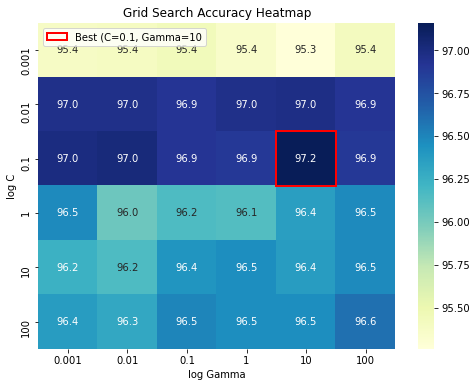

In [50]:
param_c = [0.001, 0.01, 0.1, 1, 10, 100]  
param_g = [0.001, 0.01, 0.1, 1, 10, 100]  

results = grid_search_cv(param_c, param_g, kernel='combine')
acc = [result[-1] for result in results]
print(np.round(acc, 2))

plot_gsResult(param_c, param_g, results)

In [53]:
new_k = combine_linear_rbf(X_train, X_train, 10)
train_prob = svm_problem(Y_train, new_k, isKernel=True)
model = svm_train(train_prob, '-t 4 -c 0.1 -g 10')

new_k_test = combine_linear_rbf(X_test, X_train, 0.01)
svm_predict(Y_test, new_k_test, model)

Accuracy = 95.92% (2398/2500) (classification)


([1.0,
  4.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  4.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  1.0,
  1.0,